In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import SelectFromModel 
from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

## Loading Dataset

Please note that before running the code, you will need all the GDSC files. They can be found on the drive (https://drive.google.com/drive/u/1/folders/11omvpOttkdZZgv_ppbtcCbojkuVR-D61) or directly on the GDSC website.

In [3]:
SCORE = "AUC" #how the sensitivity of the drug is computed; other option: "AUC" 
SAVE = False #whether to save the final matrix or not
PATH = "data/Final matrices/" #where your data is located

N_SPLITS = 5
DRUG_NAMES = {"CI-1040": ["MYC_mut","RB1_mut","ERBB2_amp","BRAF_mut","KRAS_mut","NRAS_mut"]#,
              #"PD0325901": ["MYC_mut","RB1_mut","ERBB2_amp","BRAF_mut","KRAS_mut","NRAS_mut"],
              #"Refametinib":["MYC_mut","RB1_mut","ERBB2_amp","BRAF_mut","KRAS_mut","NRAS_mut"],
              #"VX-11e":["RB1_mut","ERBB2_amp","CCND1_amp","BRAF_mut","KRAS_mut","NRAS_mut"],
              #"Afatinib":["KRAS_mut","NRAS_mut","EGFR_amp","ERBB2_amp","FOXP3_del"],
              #"Pelitinib":["BRAF_mut","RB1_mut","MAPK1_del","MYC_mut","EGFR_mut","CDKN1B_del"]
             }

### Response

In [4]:
def scale_data(X_train, X_test):
    
    feature_names = list(X_train) # Store the feature names
    
    sc = StandardScaler()  # Defines the scaler
    X_train = pd.DataFrame(sc.fit_transform(X_train))  # Scales the training data
    X_test = pd.DataFrame(sc.transform(X_test))  # Scales the validation data

    # Replace feature names in the database (they are lost during scaling)
    X_train.columns = feature_names
    X_test.columns = feature_names
    
    return X_train, X_test

In [5]:
def lasso_feature_reduction(X_train, X_val, y_train, Cst = 0.01):
    
    clf = LinearSVC(C = Cst, penalty = "l1", dual = False) #SVC(kernel = 'linear', C = Cst)
    clf.fit(X_train.values, y_train)
    
    model = SelectFromModel(clf, prefit=True, threshold=-np.inf, max_features = 300)
    new_X_train = model.transform(X_train.values)
    new_X_val = model.transform(X_val.values)
    
    return pd.DataFrame(new_X_train), pd.DataFrame(new_X_val)


In [6]:
def rf_feature_reduction(X_train, X_val, y_train, N_ESTIMATORS = 500):
    
    clf = RandomForestClassifier(n_estimators = N_ESTIMATORS, n_jobs = -1, class_weight = "balanced", random_state = 32)
    clf = clf.fit(X_train.values, y_train.values)
    
    model = SelectFromModel(clf, prefit=True, threshold=-np.inf, max_features = 300)   
    new_X_train = model.transform(X_train)
    new_X_val = model.transform(X_val)
    
    importances = clf.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0) --> std dev but we don't use it anyway
    
    return pd.DataFrame(new_X_train), pd.DataFrame(new_X_val), importances

In [7]:
def run_PCA(X, NB_COMPONENTS, kf = 5, verbose = 5):

    if verbose > 1:
        print("Running PCA...")
        print("Number of features before PCA: ", len(X.columns))

    # Starting PCA
    my_PCA = PCA(n_components=NB_COMPONENTS)
    reduced_X = pd.DataFrame(my_PCA.fit_transform(np.array(X.values), y=None))
    reduced_X.columns = [f"PC{elem}" for elem in range(NB_COMPONENTS)]
    
    # Plotting
    if verbose > 0:
        fig = plt.figure()
        g = sns.lineplot(x = range(1, NB_COMPONENTS+1), y = my_PCA.explained_variance_ratio_)
        plt.xlabel('Principal Component')
        plt.ylabel('Variance (Component Scores)')
        plt.title('Screen Plot of Principal Components')
        plt.show(); 
    
    if verbose > 1:
        print("Number of combined features after PCA: ",len(list(reduced_X)))
    
    return reduced_X   

In [23]:
def calculate_performances(DRUG_NAME, ML_matrix, PATH, SCORE, N_SPLITS, verbose = 5):
    
    ## Look at the distribution of the response
    
    if verbose > 0:
        print(f"\nDistribution of responses for {DRUG_NAME}")
        fig = plt.figure(figsize = (10,6))
        sns.distplot(ML_matrix[[DRUG_NAME]])
        plt.title("Plot of the distribution of AUC values for "+ DRUG_NAME)
        plt.xlabel("AUC")
        plt.ylabel("Proportion of cell poplations")
        plt.grid(True);
        plt.savefig("data/Results/Plots/distribution.png")
        plt.show()
        

    #_______________________________________________________________________________________________________#
    
    ## Data Categorisation and feature matrix preparation
    print("\nCategorisation of the data...")
    # The data is divided in quartiles. Upper/lower third quartile thresholds were used for discretization. 
    # Everything that is in the middle is discarded. See [this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3995541/) paper.
    # Splitting at the median or mean, although keeping more cells, leads to poorer results.
    
    if verbose > 1:
        print("The lower threshold used here is the lower third quartile = ", ML_matrix[DRUG_NAME].quantile([0.25,0.75])[0.25])
        print("The upper threshold used here is the uppder third quartile = ", ML_matrix[DRUG_NAME].quantile([0.25,0.75])[0.75])
    ML_matrix["Response"] = pd.cut(ML_matrix[DRUG_NAME], [np.min(ML_matrix[DRUG_NAME]), ML_matrix[DRUG_NAME].quantile([0.25,0.75])[0.25], ML_matrix[DRUG_NAME].quantile([0.25,0.75])[0.75], np.max(ML_matrix[DRUG_NAME])], labels = ["resistant","medium", "sensitive"])
    #ML_matrix["Response"] = pd.cut(ML_matrix[DRUG_NAME], [np.min(ML_matrix[DRUG_NAME]), np.mean(ML_matrix[DRUG_NAME]) - 0.5*np.std(ML_matrix[DRUG_NAME]), np.mean(ML_matrix[DRUG_NAME]) + 0.5*np.std(ML_matrix[DRUG_NAME]), np.max(ML_matrix[DRUG_NAME])], labels = ["resistant","medium","sensitive"])
    ML_matrix = ML_matrix.drop([DRUG_NAME], axis = 1)
    
    #Drop all the "medium" classes and NaNs
    ML_matrix = ML_matrix.drop(ML_matrix[ML_matrix["Response"] == "medium"].index)  
    
    # Convert the response to a float
    ML_matrix["Response"] = [0 if x=='resistant' else 1 for x in ML_matrix['Response']]
    
    # Structure of the feature matrix
    print(f"\tStructure of the final matrix for {DRUG_NAME}:")
    print("\t\tNumber of resistant cells: ", len(ML_matrix[ML_matrix["Response"] == 0]))
    print("\t\tNumber of sensitive cells: ", len(ML_matrix[ML_matrix["Response"] == 1]))
    print("\t\tTotal number of cells: ", len(ML_matrix.index))
    print(f'\n\t\tThe baseline accuracy for {DRUG_NAME} is {100*np.round(max(len(ML_matrix[ML_matrix["Response"] == 1])/len(ML_matrix.index),len(ML_matrix[ML_matrix["Response"] == 0])/len(ML_matrix.index)),2)}%')
    
    #_______________________________________________________________________________________________________#
    
    ## Run the different models and feature selection methods
    
    print(f"\nRunning the models with a {N_SPLITS}-fold cross-validation...")
    print("Please wait. This can take up to a minute.")
    
    # Create our feature and response matrix
    X = ML_matrix.drop("Response", axis = 1)
    y = ML_matrix["Response"].astype('float64')
        
    # Define our models    
    models = [SVC(random_state=40, probability = True),
              LogisticRegression(solver= 'saga', max_iter=5000, random_state=41),
              MLPClassifier(max_iter=5000, random_state=42),
              RandomForestClassifier(n_estimators=300, max_depth = 3, max_leaf_nodes = 10, random_state=43)]
    
    model_names = ['SVM', 'Logistic Regression', 'MLP', 'Random Forest']
    
    # Define our final result matrix
    final_results = pd.DataFrame(columns = model_names)     
          
    # Run all models
    # Run PCA
    final_results = pretty_run(final_results, X, y, models, model_names, N_SPLITS, DRUG_NAME, FS = "PCA", index_name = "Principal Component Analysis", verbose = verbose)  
          
    # Run RFE
    final_results = pretty_run(final_results, X, y, models, model_names, N_SPLITS, DRUG_NAME, FS = "RFE", index_name = "Recursive Feature Elimination", verbose = verbose)
    
    # Run Lasso Feature Selection
    final_results = pretty_run(final_results, X, y, models, model_names, N_SPLITS, DRUG_NAME, FS = "LASSO", index_name = "Lasso Feature Selection", verbose = verbose)
          
    # Run Random Forest Feature Selection
    final_results = pretty_run(final_results, X, y, models, model_names, N_SPLITS, DRUG_NAME, FS = "RF", index_name = "Random Forest Feature Selection", verbose = verbose)
          
    # Run with no feature selection
    final_results = pretty_run(final_results, X, y, models, model_names, N_SPLITS, DRUG_NAME, FS = "None", index_name = "No feature selection", verbose = verbose)
    
    print(f"All the models were run on {DRUG_NAME} successfully!")
    
    return final_results

In [24]:
def pretty_run(final_results, X, y, models, model_names, N_SPLITS, DRUG_NAME, FS, index_name, verbose = 5):
    
    for i in range(len(models)):
        if verbose > 0:
            print('______________________\n')
            print('Running',model_names[i],'and',index_name)
        perf = run_model(X, y, models[i], FS = FS, n_splits = N_SPLITS, verbose = verbose)
        final_results.loc[index_name,model_names[i]] = perf[2]
    
    final_results.loc[index_name,"Drug"] = DRUG_NAME
    return final_results

In [25]:
def run_model(X, y, clf, FS = "None", n_splits = 5, verbose = 5):
    
    train_accuracies, val_accuracies, rocs = [],[],[]
    
    if FS == "PCA":
        X = run_PCA(X, NB_COMPONENTS = len(X.columns), verbose = verbose)
        
    # Define a cross-validation (shuffleSplit here)
    ss = ShuffleSplit(n_splits, test_size=0.2, random_state=0)

    for count, (training_indices, val_indices) in enumerate(ss.split(X, y), 1):
        
        if verbose > 1:
            print(f'Cross-validation: {count}/{n_splits}')

        # Prepare the test and training set     
        X_train = X.iloc[training_indices,:]
        y_train = y.iloc[training_indices]
        X_val = X.iloc[val_indices,:]
        y_val = y.iloc[val_indices]
        if verbose > 1:
            print(f"The validation set corresponds to roughly {np.round(100*(len(X_val.index)/len(X.index)),2)}% of the total data.") 
        
        #Scaling the features -- useful for most classifier except RF and co
        X_train, X_val = scale_data(X_train, X_val)
        
        if FS == "RFE":            
            selector = RFE(estimator = LinearSVC())
            selector = selector.fit(X_train, y_train)
            X_train = X_train[X_train.columns[selector.support_]]
            X_val = X_val[X_val.columns[selector.support_]]
        elif FS == "LASSO":
            X_train, X_val = lasso_feature_reduction(X_train, X_val, y_train)
        elif FS == "RF":
            X_train, X_val, impor = rf_feature_reduction(X_train, X_val, y_train)
        elif (FS == "None") | (FS == "PCA"):
            pass
        else:
            print("Check your feature selection method. Enter either 'RFE', LASSO', 'RF' or 'None'.")
            return
        
        # Fit the classifier
        clf.fit(X_train.values.tolist(), y_train.values)        
        
        # Predict the classes
        y_pred = clf.predict(X_val.values.tolist())
        
        # Calculate the performance metrics 
        train_acc = accuracy_score(y_train.values.tolist(), clf.predict(X_train.values.tolist()))
        val_acc = accuracy_score(y_val.values.tolist(), y_pred)
        roc_auc = roc_auc_score(y_val.values, clf.predict_proba(X_val.values)[:, 1])
        
        if verbose > 1:
            print(f"Training accuracy {count}: {train_acc}")
            print(f"Validation accuracy {count}: {val_acc}")
            print(f"ROC AUC {count}: {roc_auc}")
    
        # Add the performances to their corresponding lists
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        rocs.append(roc_auc)
    if verbose > 1:
        print("_________________________________________________________________________________")   
    if verbose > 0:
        print(f'\tAverage Training Accuracy: {np.round(100*np.mean(train_accuracies), 2)} +/- {np.round(100*np.std(train_accuracies),2)}%.')
        print(f'\tAverage Validation Accuracy: {np.round(100*np.mean(val_accuracies),2)} +/- {np.round(100*np.std(val_accuracies),2)}%.')
        print(f'\tAverage AUC {np.round(100*np.mean(np.array(rocs)),2)} +/- {np.round(100*np.std(np.array(rocs)),2)}%.')
    
    return 100*np.mean(train_accuracies), 100*np.std(train_accuracies), 100*np.mean(val_accuracies), 100*np.std(val_accuracies), 100*np.mean(np.array(rocs)), 100*np.std(np.array(rocs))


Investigating CI-1040... 
Number of cells:  758

Distribution of responses for CI-1040


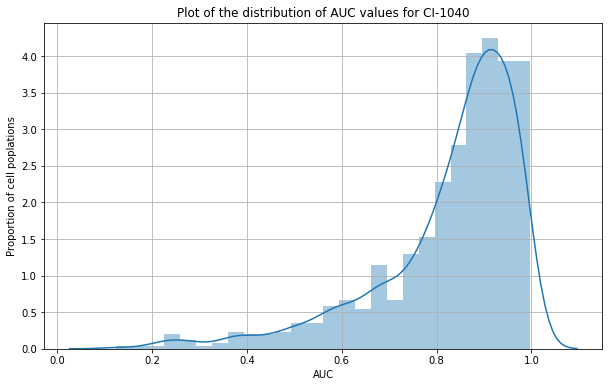


Categorisation of the data...
The lower threshold used here is the lower third quartile =  0.7740724975
The upper threshold used here is the uppder third quartile =  0.9318325812499999
	Structure of the final matrix for CI-1040:
		Number of resistant cells:  189
		Number of sensitive cells:  191
		Total number of cells:  380

		The baseline accuracy for CI-1040 is 50.0%

Running the models with a 5-fold cross-validation...
Please wait. This can take up to a minute.
______________________

Running SVM and Principal Component Analysis
Running PCA...
Number of features before PCA:  6


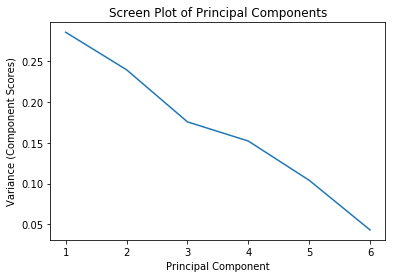

Number of combined features after PCA:  6
Cross-validation: 1/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 1: 0.7598684210526315
Validation accuracy 1: 0.8157894736842105
ROC AUC 1: 0.8386187455954897
Cross-validation: 2/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 2: 0.7697368421052632
Validation accuracy 2: 0.7894736842105263
ROC AUC 2: 0.8104643104643104
Cross-validation: 3/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 3: 0.7861842105263158
Validation accuracy 3: 0.7105263157894737
ROC AUC 3: 0.7038327526132405
Cross-validation: 4/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 4: 0.7796052631578947
Validation accuracy 4: 0.7368421052631579
ROC AUC 4: 0.7765072765072765
Cross-validation: 5/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 5: 0.7796052631578947
Validation accuracy 5: 0.

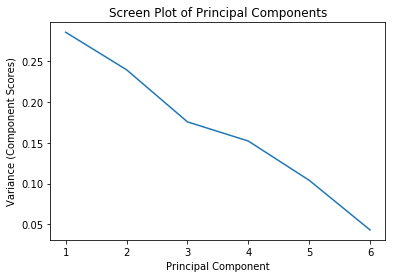

Number of combined features after PCA:  6
Cross-validation: 1/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 1: 0.75
Validation accuracy 1: 0.8157894736842105
ROC AUC 1: 0.8527131782945737
Cross-validation: 2/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 2: 0.756578947368421
Validation accuracy 2: 0.7894736842105263
ROC AUC 2: 0.8406098406098406
Cross-validation: 3/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 3: 0.7697368421052632
Validation accuracy 3: 0.7368421052631579
ROC AUC 3: 0.8271777003484321
Cross-validation: 4/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 4: 0.7697368421052632
Validation accuracy 4: 0.7368421052631579
ROC AUC 4: 0.7910602910602911
Cross-validation: 5/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 5: 0.7697368421052632
Validation accuracy 5: 0.75
ROC AUC 5: 0

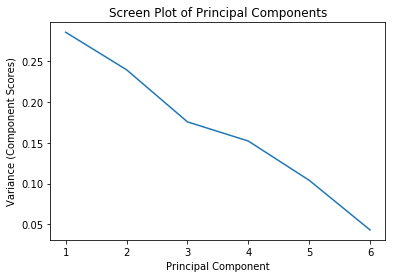

Number of combined features after PCA:  6
Cross-validation: 1/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 1: 0.7598684210526315
Validation accuracy 1: 0.8157894736842105
ROC AUC 1: 0.8590556730091614
Cross-validation: 2/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 2: 0.7697368421052632
Validation accuracy 2: 0.7894736842105263
ROC AUC 2: 0.8354123354123354
Cross-validation: 3/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 3: 0.7828947368421053
Validation accuracy 3: 0.7368421052631579
ROC AUC 3: 0.7986062717770036
Cross-validation: 4/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 4: 0.7796052631578947
Validation accuracy 4: 0.7368421052631579
ROC AUC 4: 0.7723492723492723
Cross-validation: 5/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 5: 0.7763157894736842
Validation accuracy 5: 0.

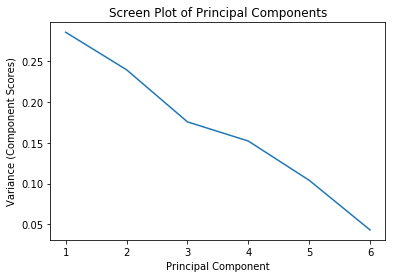

Number of combined features after PCA:  6
Cross-validation: 1/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 1: 0.7598684210526315
Validation accuracy 1: 0.8026315789473685
ROC AUC 1: 0.8484848484848485
Cross-validation: 2/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 2: 0.7697368421052632
Validation accuracy 2: 0.7894736842105263
ROC AUC 2: 0.8309078309078308
Cross-validation: 3/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 3: 0.7861842105263158
Validation accuracy 3: 0.7236842105263158
ROC AUC 3: 0.78397212543554
Cross-validation: 4/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 4: 0.7796052631578947
Validation accuracy 4: 0.7368421052631579
ROC AUC 4: 0.7695772695772696
Cross-validation: 5/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 5: 0.7796052631578947
Validation accuracy 5: 0.73

Training accuracy 1: 0.7598684210526315
Validation accuracy 1: 0.8157894736842105
ROC AUC 1: 0.8569415081042989
Cross-validation: 2/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 2: 0.7697368421052632
Validation accuracy 2: 0.7894736842105263
ROC AUC 2: 0.8371448371448371
Cross-validation: 3/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 3: 0.7828947368421053
Validation accuracy 3: 0.7368421052631579
ROC AUC 3: 0.8013937282229966
Cross-validation: 4/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 4: 0.7796052631578947
Validation accuracy 4: 0.7368421052631579
ROC AUC 4: 0.7792792792792792
Cross-validation: 5/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 5: 0.7763157894736842
Validation accuracy 5: 0.75
ROC AUC 5: 0.8249289772727273
_________________________________________________________________________________
	Average Trainin

Training accuracy 1: 0.7598684210526315
Validation accuracy 1: 0.8157894736842105
ROC AUC 1: 0.8569415081042989
Cross-validation: 2/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 2: 0.7697368421052632
Validation accuracy 2: 0.7894736842105263
ROC AUC 2: 0.8371448371448371
Cross-validation: 3/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 3: 0.7828947368421053
Validation accuracy 3: 0.7368421052631579
ROC AUC 3: 0.8013937282229966
Cross-validation: 4/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 4: 0.7796052631578947
Validation accuracy 4: 0.7368421052631579
ROC AUC 4: 0.7792792792792792
Cross-validation: 5/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 5: 0.7763157894736842
Validation accuracy 5: 0.75
ROC AUC 5: 0.8249289772727273
_________________________________________________________________________________
	Average Trainin

SVM Logistic Regression      MLP  \
Drug    Methods                                                                 
CI-1040 Principal Component Analysis     75.7895             76.5789  76.5789   
        Recursive Feature Elimination    76.3158             76.3158  76.3158   
        Lasso Feature Selection          75.7895             76.5789  76.5789   
        Random Forest Feature Selection  75.7895             76.5789  76.5789   
        No feature selection             75.7895             76.5789  76.5789   

                                        Random Forest  
Drug    Methods                                        
CI-1040 Principal Component Analysis          75.7895  
        Recursive Feature Elimination         76.3158  
        Lasso Feature Selection               76.3158  
        Random Forest Feature Selection       76.3158  
        No feature selection                  76.3158

In [26]:
def run_all_drugs(DRUG_NAMES, PATH, SCORE, N_SPLITS, verbose = 5):
    
    final_results = pd.DataFrame()
    
    for drug in DRUG_NAMES:

        print(f"Investigating {drug}... ")

        # Read the corresponding ML matrix
        ML_matrix = pd.read_csv(PATH + f"{drug}.csv")
        ML_matrix.set_index("Cell_line", inplace = True)
        ML_matrix = ML_matrix.dropna()

        print("Number of cells: ", len(ML_matrix.index))
        if verbose > 3:
            ML_matrix.head() #Show the head of the dataframe for that drug

        results_drug = calculate_performances(drug, ML_matrix, PATH, SCORE, N_SPLITS, verbose = verbose)
        
        final_results = pd.concat([final_results,results_drug])
                                          
        print("_________________________________________________________________________________________________________")
        
    final_results.index.name = "Methods"
    
    return final_results.reset_index(drop=False).set_index(["Drug","Methods"])
                                          
final_results = run_all_drugs(DRUG_NAMES, PATH, SCORE, N_SPLITS, verbose = 2)
display(final_results)

In [12]:
#final_results.to_csv(f'data/Results/Netphix_results.csv', index_label = ["Drug","Methods"])